# ALS Fitting Code Template: H<sub>2</sub>O<sub>2</sub> Photolysis Example

This notebook serves as an example of how to use the ALS.KineticModel class ('ALS.py') to fit kinetics data.  Documentation for the class methods is provided throughout.  An example of a user kinetic model (passed to the ALS.KineticModel instantiator) is provided for the H<sub>2</sub>O<sub>2</sub> photolysis system in 'ex_model_1.py'.  It is recommended to use this notebook and  the example user model file as templates, modifying them to construct and fit new models.

**Whenever a cell in this notebook is modified, it must be rerun.**  It is also necessary to rerun any other cells that rely on values computed in the modified cell.  For example, if the code for step 1 of a setup task is modified, you will likely need to rerun cells for all steps of that setup task.

The goal of the fit is to solve the following optimization problem:

$$\vec{p}_{opt} = \underset{\vec{p}}{\arg\min} \sum_{i\in\{species\}} w_i \cdot \bigg[ \sum_{t_j\in\{t\}} \Big( \frac{y_{i,obs}(t_j) - y_{i,mod}(t_j, \vec{p})}{y_{i,err}(t_j)} \Big)^2 \bigg]$$
Where:
 - $\vec{p}_{opt}$ is the optimized parameter vector.
 - $w_i$ is the scalar weight of species $i$ in the cost function.
 - $y_{i,obs}(t_j)$ is the observed signal of species $i$ at time $t_j$.
 - $y_{i,err}(t_j)$ is the uncertainty in the observed signal of species $i$ at time $t_j$.
 - $y_{i,mod}(t_j, \vec{p})$ is the modeled signal of spceies $i$ at time $t_j$.  It is computed by integrating the user model in steps dictated by the photolysis gradient, convolving the concentration profiles with the instrument response function (IRF), and finally scaling by a species-specific scale factor ${S_i}$ to convert from concentration units to ion signal.

***Advice on performing fits:***

Like most nonlinear fits, the results can be highly sensitive to the choice of initial guess, particularly as the number of fitted parameters increases.  Some tips if your results seem overly sensitive to the initial guess:

1. Use the ALS.KineticModel.plot_data_model method to check that your initial guess is reasonable.  If you're unable to get something visually close by adjusting the initial guess, then it's a good indication that your model is not describing the phenomena you are trying to capture, some fixed parameters are inaccurate, etc.  I've found that the results are much more sensitive to initial guess when the fit quality is visually poor.

2. Consider the uncertainties on the optimized parameters.  Do the results change substantially as the initial guess is varied, or are they all within error?  The bootstrap method tends to produce substantially more accurate (and larger) uncertainties than those determined from the estimated fit Jacobian.

3. Also consider the covariance between parameters.  If an optimized parameter changes as the initial guess is varied, does a parameter to which it is highly correlated also change?  This suggests your model / data cannot independently determine these parameters, and they might only be varying within error (see above point).

4. Try changing the ftol, xtol, or maxfev arguments passed to the leastsq solver (identify which is causing the solver to terminate) to achieve tighter convergence criteria.  Although in practice, I haven't seen this make much of a difference.

***Other tips:***

 - Setting *err_weight* to False tends to give better visual fit quality when some fitted species have worse signal-to-noise than others.  (For example, in this notebook, OH has poor signal-to-noise and its fit looks visually incorrect if *err_weight* is True.)
 - This code can also be used to fit non-ALS kinetics data, so long as all time points are integer multiples of 0.02 ms.  Simply set the *apply_IRF* and *apply_PG* flags to False.  If there is no photolysis offset in the non-ALS experiment, then fix *t0* at 0.  The interpretation of the species-specific scale factor ${S_i}$ will no longer be related to the photoionization cross section, but instead to details of the non-ALS epxeriment.

# Setup: Modules

Be sure to run this code block first.  Imports all of the modules necessary for the rest of the notebook.  Note that the ALS module also has matplotlib and scipy as dependencies, even though we do not need to import them within this notebook.

This example notebook was developed and tested using the following packages/versions.  Other versions may also work.    
 - python (3.6.1)
 - numpy (1.12.1)
 - pandas (0.20.1)
 - scipy (0.19.0)
 - matplotlib (2.2.2)
 - ipython (5.3.0)
 - ALS (1.0.0)

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import ALS

# Setup: User Model

#### Step 1: Define the user model. 

This is the step that requires the most coding on behalf of the user.  I prefer to code the user model in a separate text editor (Sublime Text), save it as a module, and then import it.  The 'ex_model_1.py' file contains the example model_H2O2_depletion with comments providing an explanation how to structure the user model.  It is recommended to follow the template provided there, although any function that has the correct arguments / returns (see below) will work.

*function* **user_model**(*t, model_params*)

**Parameters:**

>**t : *ndarray***
>>Time axis (ms) over which to integrate the model.

>**model_params : *dict***
>>Keys (strings) are the names of the parameters used by the model; values (floats) are the parameter values.  Any parameters that will be fit or included in a monte carlo simulation of systematic error should be included.

>>Only one parameter is required: 'X0' is the key and the initial radical concentration immediately after photolysis is its value.

**Returns:** It is only required to return species for which there is observable data to fit; returning other species from the model is optional, but could be useful when plotting model output.  The keys of *m* and *c* must be the same.

>**m : *dict***
>>Keys (strings) are the names of species returned by the model; values (floats) are their masses (amu).

>**c : *dict***
>>Keys (strings) are the names of species returned by the model; values (ndarray) are concentrations (molc/cm<sup>3</sup>) corresponding to times in *t*.

In [2]:
from ex_model_1 import model_H2O2_depletion

#### Step 2: Instantiate the KineticModel object.

*class* **ALS.KineticModel**(*user_model, err_weight=True, fit_pre_photo=False, apply_IRF=True, apply_PG=True, t_PG=1.0*)

**Parameters:**

>**user_model : *function***
>>The user model function defined in Step 1.

>**err_weight : *bool, optional***
>> If True, the contribution of each data point to the fit cost function is weighted by its uncertainty.  If False, then the error terms are omitted.  (See cost function in the introduction.)

>**fit_pre_photo : *bool, optional***
>> If True, the fit cost function is calculated across all *t*.  If False, the fit cost function is calculated only using data for which *t* ≥ *t0*.  If *t0* is being fit, then this MUST be set to True.  While every model is different, this should generally be left at the default value of False unless *t0* is being fit.

>**apply_IRF : *bool, optional***
>> If True, then the output of the model integration will be convolved with the IRF.

>**apply_PG : *bool, optional***
>> If True, then the model will be integrated in steps (set by *t_PG*) with a linearly changing initial radical concentration.

>**t_PG : *float, optional***
>>The step size (ms) used for updating the radical concentration and implementing the photolysis gradient.  Required to be an integer multiple of 0.02 ms; recommended to be an integer multiple of *tbin* \* 0.02 ms.  Smaller values will give more accurate results but increase computation time.  The default value of 1 ms is often a good tradeoff.  Ignored if *apply_PG* is False.

In [3]:
model = ALS.KineticModel(model_H2O2_depletion, err_weight=False)

# Setup: Species Data

#### Step 1: Load the species data and define time variables.

This is a workspace to load the data.  The time axis (*t*), *tbin*, *t_start*, and *t_end* are also defined for passing to the ALS.KineticModel methods.  This can be customized or the template below can be followed.

The data can have any units (typically ion counts or normalized ion signal); this example uses ion counts.  The scaling of the signal to concentration units is handled in the ALS parameters setup section below.

The template assumes that kinetics traces were extracted for each species over the entire time interval [-20 ms, 130 ms) with step size of *tbin* \* 0.02 ms.  The column headers are the names of the species.  The 'val' file contains the data values and the 'err' file contains the corresponding uncertainties.  See 'ex_data_val_1.csv' and 'ex_data_err_1.csv' for an example of the formatting.

In [5]:
# Inputs
tbin = 10                    # tbin used when data was extracted using Igor
t_start = -20                # Will trim the data to t_start inclusive (ms) - must be integer multiple of tbin * 0.02 ms
t_end = 59.8                 # Will trim the data to t_end inclusive (ms) - must be integer multiple of tbin * 0.02 ms
fn_val = 'ex_data_val_1.csv' # Filename for the data values
fn_err = 'ex_data_err_1.csv' # Filename for the uncertainties

# Step size of time axis (ms)
delta_t = tbin * 0.02                    

# Calculate the time axis [-20 ms, 130 ms)
t = np.linspace(-20,130,num=round(150/delta_t),endpoint=False)

# Load the data values and uncertainties
df_val = pd.read_csv(fn_val)
df_err = pd.read_csv(fn_err)

# Determine indices of data to drop
idx_start = np.abs(t-t_start).argmin()
idx_end = np.abs(t-t_end).argmin()
drop_indices = np.concatenate((np.arange(idx_start),np.arange(idx_end+1,t.size)))

# Trim the time axis and data to [t_start, t_end]
t = t[idx_start:idx_end+1]
df_val = df_val.drop(drop_indices, axis=0).reset_index(drop=True)
df_err = df_err.drop(drop_indices, axis=0).reset_index(drop=True)

#### Step 2: Organize species data into a DataFrame.

The *df_data* DataFrame will be passed to the ALS.KineticModel methods.  Rows correspond to each species; the indices are species names and must match a species name returned by the user model.  The columns are detailed below.  If you used the recommended template from Step 1, then you can also follow the template below.

**Columns:**

>**val : *ndarray***
>>Array containing the signal for the species.  This is $y_{i,obs}(t)$ using the notation of the introduction.

>**err : *ndarray***
>>Array containing the signal uncertainties.  This is $y_{i,err}(t)$ using the notation of the introduction.

>**fit : *bool***
>>If True, this species is included in the calculation of the fit cost function.  If False, then it is omitted.

>**weight : *float***
>>The scalar weight of the species in the cost function.  This is $w_i$ using the notation of the introduction.

In [6]:
df_data = {}
df_data['H2O2'] = {'val':df_val['H2O2'].values, 'err':df_err['H2O2'].values, 'fit':True, 'weight':1.0}
df_data['HO2']  = {'val':df_val['HO2'].values,  'err':df_err['HO2'].values,  'fit':True, 'weight':1.0}
df_data['OH']   = {'val':df_val['OH'].values,   'err':df_err['OH'].values,   'fit':True, 'weight':1.0}
df_data = pd.DataFrame.from_dict(df_data, orient='index')

display(df_data)

,val,err,fit,weight
H2O2,"[6135.0, 6162.0, 6025.0, 6005.0, 6027.0, 6101....","[78.326, 78.498, 77.621, 77.492, 77.634, 78.10...",True,1.0
HO2,"[-3.15, -4.15, -3.15, -4.15, 5.85, 6.85, -1.15...","[5.0, 4.899, 5.0, 4.899, 5.831, 5.9161, 5.1962...",True,1.0
OH,"[-0.82, 0.18, 0.18, -0.82, -0.82, -0.82, 1.18,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.4142, 1.0, 1....",True,1.0


# Setup: Model and ALS Parameters

**Note:** The way the code handles scale factors and uncertainty for stable pre-photolysis species of known concentration will likely change in future versions.  We need to properly account for the correlation between pre-photolysis concentration (a model parameter) and the scale factor (an ALS parameter). 

#### Step 1: Calculations for fixed parameters.

This is a workspace for any fixed model / ALS parameters that require calculation.  Feel free to modify as necessary; there is no recommended format as this will be model-specific.  Variables computed here are used in later steps.  

In [39]:
# Fix A (IRF parameter), B (photolysis gradient parameter), t0 (photolysis offset)
A = -0.022  # ms2/amu
B = 4.85e-3 # ms-1
t0 = -0.5   # ms

idx_zero = np.abs(t-t0).argmin()

# Fix initial H2O2 concentration and H2O2 scale factor - ignore uncertainties for now
c_H2O2_0 = 5.25e14
c_H2O2_0_err = 0
S_H2O2 = df_val.iloc[:idx_zero,df_val.columns.get_loc('H2O2')].mean() / c_H2O2_0
S_H2O2_err = 0

T = 298 # K
P = 30  # Torr
M = (P*133.3224)/(1.38e-23*T)/1e6 # molc/cm3

# Helper function to compute bimolecular rate constants
def calc_k_bi(A, E_R):
    k_T = A*np.exp(-E_R/T)
    return k_T

# Helper function to compute rate constant uncertainty factor (JPL format)
def calc_f(f_298, g):
    f_T = f_298*np.exp(np.abs(g*(1/T - 1/298.0)))
    return f_T

# Calculate bimolecular rate constants and their uncertainties (cm3/molc/s)

# OH + H2O2 --> HO2 + H2O
# JPL 2015, temperature independent over 200 - 300 K
k1 = 1.8e-12
k1_err = k1*(calc_f(1.15, 45) - 1)

# OH + HO2 --> H2O + O2
# JPL 2015, T = 252-420 K
k2 = calc_k_bi(4.8e-11, -250)
k2_err = k2*(calc_f(1.15, 50) - 1)

# HO2 + HO2 --> H2O2 + O2
# JPL 2015, T = 222-1120 K, M is air
k3a = calc_k_bi(3e-13, -460)
k3a_err = k3a*(calc_f(1.15, 100) - 1)
k3b = calc_k_bi(2.1e-33*M, -920)
k3b_err = k3b*(calc_f(1.2, 200) - 1)
k3 = k3a + k3b
k3_err = (k3a_err**2 + k3b_err**2)**0.5

#### Step 2: Organize model parameters into a DataFrame.

The *df_model_params* DataFrame will be passed to the ALS.KineticModel methods.  Rows correspond to each model parameter; the indices are parameter names and must match each parameter in the user model.  The columns are detailed below.  It is recommended to use the code template in the cell below.

As is the case with the user model, the only required model parameter is 'X0', which corresponds to the initial radical concentration immediately after photolysis.

**Columns:**

>**val : *float***
>>Value of the parameter.  If *fit* is True, then this will be treated as the initial guess.

>**err : *float***
>>Absolute uncertainty in the parameter (1 standard error).  Used to vary the value of the parameter during monte carlo simulations of systematic model uncertainty.  Ignored if set to 0 or if *fit* is True.

>**fit : *bool***
>>If True, then this parameter will be optimized during a fit.  If False, then the parameter will be fixed during a fit.

In [40]:
df_model_params = {}
df_model_params['X0'] =         {'val':4.2e12,   'err':0,            'fit':True }
df_model_params['c_H2O2_0'] =   {'val':c_H2O2_0, 'err':c_H2O2_0_err, 'fit':False}
df_model_params['k_OH_wall'] =  {'val':25,       'err':0,            'fit':True }
df_model_params['k_HO2_wall'] = {'val':6,        'err':0,            'fit':True }
df_model_params['k1'] =         {'val':k1,       'err':k1_err,       'fit':False}
df_model_params['k2'] =         {'val':k2,       'err':k2_err,       'fit':False}
df_model_params['k3'] =         {'val':k3,       'err':k3_err,       'fit':False}
df_model_params = pd.DataFrame.from_dict(df_model_params, orient='index')

print('Inputted Model Params DataFrame:')
display(df_model_params)

Inputted Model Params DataFrame:


,val,err,fit
X0,4.200000e+12,0.000000e+00,True
c_H2O2_0,5.250000e+14,0.000000e+00,False
k1,1.800000e-12,2.700000e-13,False
k2,1.110663e-10,1.665994e-11,False
k3,1.449221e-12,2.108588e-13,False
k_HO2_wall,6.000000e+00,0.000000e+00,True
k_OH_wall,2.500000e+01,0.000000e+00,True


#### Step 3: Organize ALS parameters into a DataFrame.

The *df_ALS_params* DataFrame will be passed to the ALS.KineticModel methods.  Rows correspond to each ALS parameter.  There are specific requirements on the ALS parameters that must be included, which are detailed below.

**Rows:**

>**'A'**
>>The mass-independent instrument response function (IRF) parameter.  Units of ms<sup>2</sup>/amu.  Ignored if *apply_IRF* is False.

>**'B'**
>>The photolysis gradient parameter.  Units of ms<sup>-1</sup>.  Ignored if *apply_PG* is False.

>**'t0'**
>>The photolysis offset.  Units of ms.  This is the time at which the photolysis laser fires along the data time axis.

>**'S\_' + species name *(multiple)***
>>The species-specific scale factor ($S_i$) for converting the model output from concentration units ($c_{i,mod}$) to signal units ($y_{i,mod}$).  The scaling is performed as $y_{i,mod} = S_i \cdot [c]_{i,mod}$.  Assuming the signal units are dimensionless, then units of ${S_i}$ are cm<sup>3</sup>/molc.

>>There must be one of this parameter per species in *df_data* for which the *fit* field is True.  For example, if *fit* in *df_data* for species 'H2O2' is True, then there must be an 'S_H2O2' parameter.

>>The *val* of the ${S_i}$ parameter should be determined in one of the following ways:
>>1. Compute from the absolute photoionization cross sections of the species and a reference molecule.
>>2. If the species is stable pre-photolysis, compute from the known concentration and ion signal over $t < t_0$.
>>3. Otherwise, you will have to leave this as a fitted parameter.

>>For convenience, this parameter can also be included for species for which *fit* is False in *df_data*.  (For example, if you are playing around with fitting different combinations of species.)  However, be sure to set the *fit* field of ${S_i}$ to False in this case, since there will be no sensitivity to this parameter.

**Columns:**

>**val : *float***
>>Value of the parameter.  If *fit* is True, then this will be treated as the initial guess.

>**err : *float***
>>Absolute uncertainty in the parameter (1 standard error).  Used to vary the value of the parameter during monte carlo simulations of systematic model uncertainty.  Ignored if set to 0 or if *fit* is True.

>**fit : *bool***
>>If True, then this parameter will be optimized during a fit.  If False, then the parameter will be fixed during a fit.

In [41]:
df_ALS_params = {}
df_ALS_params['A'] =       {'val':A,       'err':0, 'fit':False}
df_ALS_params['B'] =       {'val':B,       'err':0, 'fit':False}
df_ALS_params['t0'] =      {'val':t0,      'err':0, 'fit':False}
df_ALS_params['S_H2O2'] =  {'val':S_H2O2,  'err':0, 'fit':False}
df_ALS_params['S_OH'] =    {'val':3.6e-11, 'err':0, 'fit':True }
df_ALS_params['S_HO2'] =   {'val':2.6e-10, 'err':0, 'fit':True }
df_ALS_params = pd.DataFrame.from_dict(df_ALS_params, orient='index')

print('Inputted ALS Params DataFrame:')
display(df_ALS_params)

Inputted ALS Params DataFrame:


,val,err,fit
A,-2.200000e-02,0,False
B,4.850000e-03,0,False
S_H2O2,1.150616e-11,0,False
S_HO2,2.600000e-10,0,True
S_OH,3.600000e-11,0,True
t0,-5.000000e-01,0,False


# Method: Plot the model in concentration units

Integrates the user model with the parameters specified in *df_model_params* and *df_ALS_params* (no fitting).  The output is plotted (and optionally saved) in concentration units.  All species returned by the user model are plotted, regardless of the *fit* field in *df_data*.  If *apply_IRF* and *apply_PG* are set to False, then this is equivalent to running a Kintecus model.

Since coding the rate equations may be tedious for larger models, it is recommended to compare this output to an equivalent Kinteucs model to ensure that the model was coded correctly.

See the file 'ex_init_model_conc_1.csv' for an example of how the output is formatted if *save_fn* is specified.

*method* **ALS.KineticModel.plot_model**(*t_start, t_end, tbin, df_model_params, df_ALS_params, delta_xtick=20.0, save_fn=None*)

**Parameters:**

>**t_start : *float***
>>Start time (ms) for the plot.  Must be an integer multiple of *tbin* \* 0.02 ms and cannot be less than -20 ms.

>**t_end : *float***
>>End time (ms) for the plot.  Must be an integer multiple of *tbin* \* 0.02 ms and must be greater than *t_start*.

>**tbin : *int***
>>The time axis step size will be *tbin* \* 0.02 ms.

>**df_model_params : *DataFrame***
>>Contains the model parameters.  See setup above for formatting.

>**df_ALS_params : *DataFrame***
>>Contains the ALS parameters.  See setup above for formatting.

>**delta_xtick : *float, optional***
>>Tick marks and labels for the time axis include zero and are spaced by *delta_xtick* (ms).

>**save_fn : *str, optional***
>>The points in the plots are saved to *save_fn* if this parameter is specified.  First column is the time axis (ms) and the remaining columns contain the concentrations (molc/cm<sup>3</sup>) for each species.

<IPython.core.display.Javascript object>


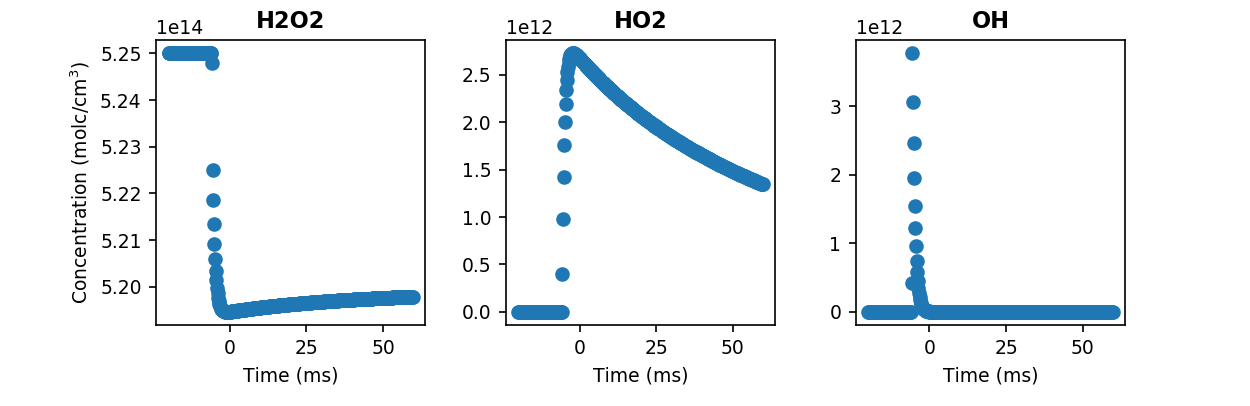

In [37]:
% matplotlib notebook

model.plot_model(t_start, t_end, tbin, df_model_params, df_ALS_params, save_fn='ex_init_model_conc_1.csv')

# Method: Plot the data and the scaled model

Integrates the user model with the parameters specified in *df_model_params* and *df_ALS_params* (no fitting).  The output is scaled by the species-specific scale factors ${S_i}$ to match the units of the data.  Both the data and scaled model are plotted, and the scaled model can be optionally saved.  Only species for which the *fit* field in *df_data* is True are included.  The value of the cost function with these parameters is also evaluated and optionally outputted.

Some example use cases for this method:
1. Adjusting the initial guesses for fitted parameters to achieve an initial model that is visually close.  This is particularly important to do when a large number of parameters are being fit.
2. Plotting a previous fit and evaluating its optimized cost without having to perform a fit again.  The 'val' fields of *df_model_params* and *df_ALS_params* should be set to the fixed parameter and optimized fitted parameter values from the previous fit.
3. Saving the optimized model of a previous fit (scaled to the units of the data) for plotting elsewhere.

See the file 'ex_init_model_scaled_1.csv' for an example of how the output is formatted if *save_fn* is specified.

*method* **ALS.KineticModel.plot_data_model**(*t, tbin, df_data, df_model_params, df_ALS_params, delta_xtick=20.0, save_fn=None, print_cost=True*)

**Parameters:**

>**t : *ndarray***
>>Time axis (ms) of the data.  All points must be greater than or equal to -20 ms and evenly spaced by *tbin* \* 0.02 ms in ascending order.

>**tbin : *int***
>>Corresponds to the spacing of *t*.  Points are evenly spaced by *tbin* \* 0.02 ms.

>**df_data : *DataFrame***
>>Contains the data.  See setup above for formatting.  Only species for which the *fit* field is True are shown.

>**df_model_params : *DataFrame***
>>Contains the model parameters.  See setup above for formatting.

>**df_ALS_params : *DataFrame***
>>Contains the ALS parameters.  See setup above for formatting.

>**delta_xtick : *float, optional***
>>Tick marks and labels for the time axis include zero and are spaced by *delta_xtick* (ms).

>**save_fn : *str, optional***
>>The scaled model points are saved to *save_fn* if this parameter is specified.  First column is the time axis (ms) and the remaining columns contain the modeled signals (scaled to the units of the data) for each species.

>**print_cost : *bool, optional***
>>If True, then the value of the cost function with these parameters is outputted.  Only species for which *fit* is True in *df_data* are included in the cost calculation.

<IPython.core.display.Javascript object>


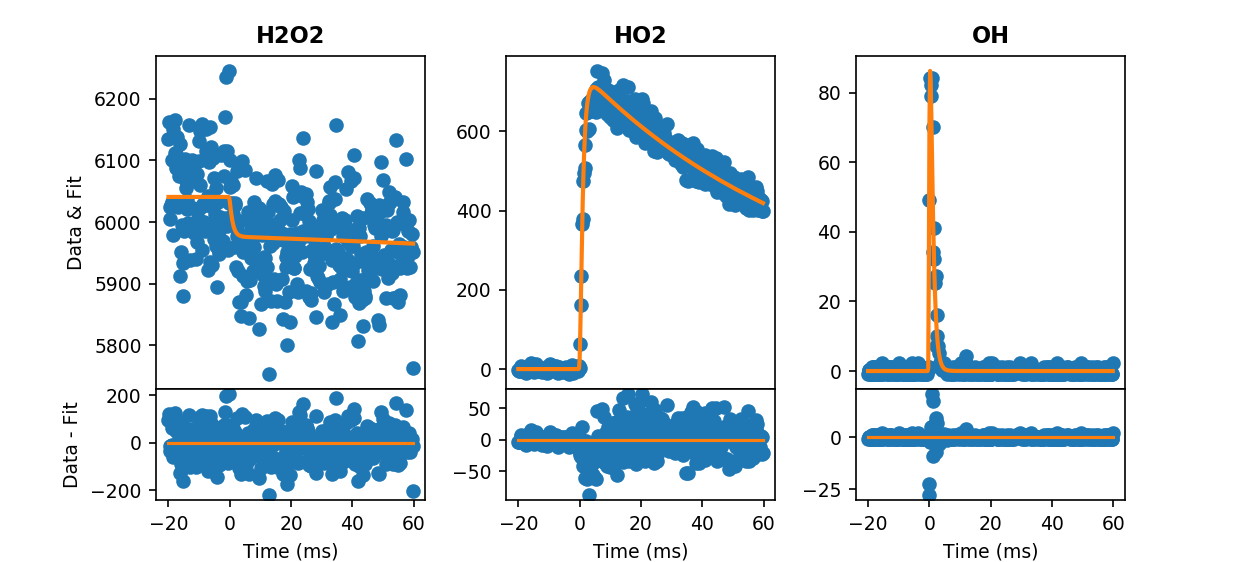


Cost Function Value = 1.56119e+06


In [11]:
% matplotlib notebook

model.plot_data_model(t, tbin, df_data, df_model_params, df_ALS_params, save_fn='ex_init_model_scaled_1.csv')

# Perform a fit

Optimization terminated successfully.
Exit Code = 2
Exit Message = The relative error between two consecutive iterates is at most 0.000000

Optimized Cost Function Value = 1.55908e+06

Optimized Parameters and Standard Errors:


,val,err
X0,4.190955e+12,6.148287e+10
k_HO2_wall,5.895733e+00,9.662193e-02
k_OH_wall,2.486664e+01,3.792039e-01
S_HO2,2.596896e-10,2.569956e-12
S_OH,3.608128e-11,7.711094e-12



Correlation Matrix:


,X0,k_HO2_wall,k_OH_wall,S_HO2,S_OH
X0,1.000000,-0.322693,-0.274972,-0.889904,-0.044905
k_HO2_wall,-0.322693,1.000000,-0.421053,0.382148,0.031160
k_OH_wall,-0.274972,-0.421053,1.000000,0.270949,-0.006262
S_HO2,-0.889904,0.382148,0.270949,1.000000,0.040573
S_OH,-0.044905,0.031160,-0.006262,0.040573,1.000000


<IPython.core.display.Javascript object>


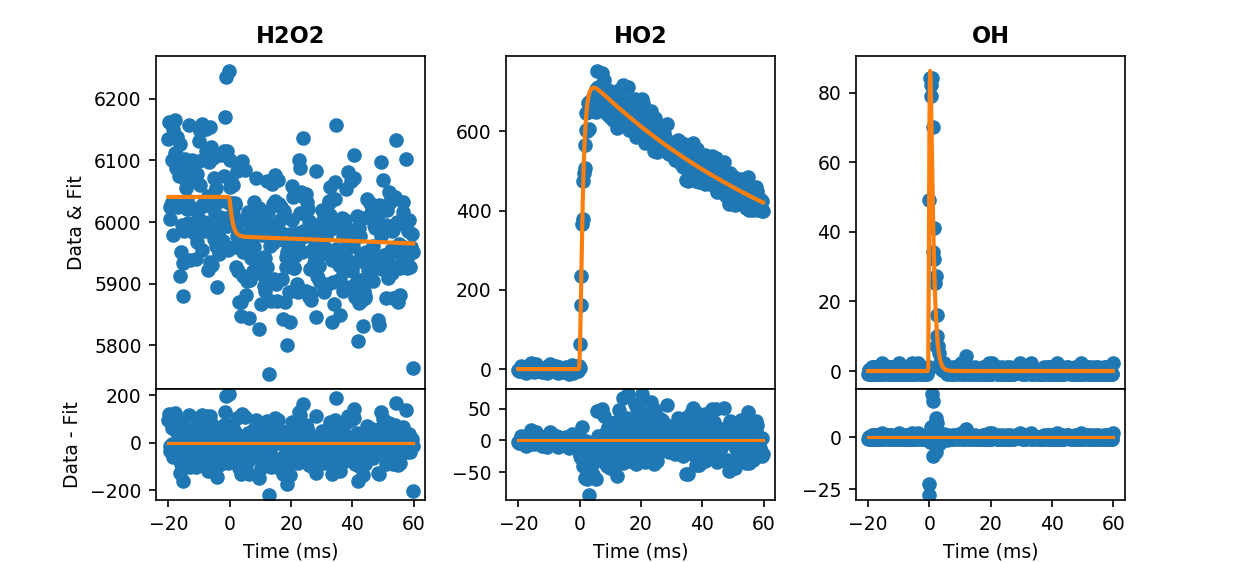

In [12]:
% matplotlib notebook

df_p, df_cov_p, df_corr_p, cost, mesg, ier \
    = model.fit(t, tbin, df_data, df_model_params, df_ALS_params, save_fn='ex_fit_model_scaled_1.csv')

In [42]:
import importlib
importlib.reload(ALS)
model = ALS.KineticModel(model_H2O2_depletion, err_weight=False)